In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import scipy as sp
import numpy as np
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords

from ast import literal_eval

requirements = pd.read_csv('../../crowdre_question/requirements.csv')
req = pd.DataFrame(requirements, columns = ['feature','benefit','tags'])
req['sentence']= req['feature'] + ', ' + req['benefit']
req.drop(['feature','benefit'],axis=1, inplace=True)

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidzhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidzhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
req.dropna(inplace=True)
req.reset_index(drop=True, inplace=True)
req['tags'] = req.tags.apply(lambda x: list(re.split(r'\W+',x)))
req

,tags,sentence
0,"[food, delivery, dinner, voice]",my smart home to be able to order delivery foo...
1,"[lights, turn, on, night]",my smart home to turn on certain lights at dus...
2,"[music, biorhythm, mood]",my smart home to sync with my biorhythm app an...
3,[television],my smart home to to ring when my favorite show...
4,"[school, classes, student]","Class Reminders, I won't be late for class"
...,...,...
2587,[pets],the house to detect if my cat or dog is trying...
2588,[kids],the house to notify me when my children are ho...
2589,[precaution],cameras on the outside to detect if suspicious...
2590,"[house, structure]",the house to notify me when the structural int...


In [4]:
len(req['tags'])

2592

In [5]:
# generate first 30 most frequent tags
y = req['tags']

from nltk.stem import WordNetLemmatizer

interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%','\'s']
STOPWORDS = set(stopwords.words('english'))

# generate first 30 most frequent tags

from nltk.stem import WordNetLemmatizer

# need to stemming the tag as well
tag_dic = {}

# counter for counting special cases
count = 0
count_air = 0
for tag_list, index in zip(req['tags'], range(len(req['tags']))):
    
    clean_list = []
    for tag in tag_list:

        # do lemmatization
        lemmatizer = WordNetLemmatizer()
        lemma_tag = lemmatizer.lemmatize(tag.lower(), 'n')

        # special case
        if lemma_tag == 'television':
            lemma_tag = 'tv'
            count += 1
        elif lemma_tag == 'conditioner' or lemma_tag == 'conditioning':
            lemma_tag = 'ac'
            count_air += 1
        # #######################
        # do stemming here
        stemmer = nltk.stem.SnowballStemmer('english')
        stem_tag = stemmer.stem(lemma_tag)
        # #######################

        if stem_tag not in (interpunctuations and STOPWORDS) and len(stem_tag) != 0:
            if stem_tag not in tag_dic:
                tag_dic[stem_tag] = 1
                clean_list.append(stem_tag)
            else:
                tag_dic[stem_tag] += 1
                clean_list.append(stem_tag)
                
    # replace with clean tag in req
    req['tags'][index] = clean_list


print('the time television has revised to tv:',count)  
print('the time air conditioner has revised to ac:',count_air)  
df = pd.DataFrame(list(tag_dic.items()), columns=['tag', 'count']).sort_values(by = 'count',axis = 0,ascending = False)
df.reset_index(drop=True, inplace=True)
print('the number of label type:',len(df))

total = 0

pd.set_option('display.max_rows', None)
#df.head(30)
df.head()

the time television has revised to tv: 39
the time air conditioner has revised to ac: 12
the number of label type: 1127


,tag,count
0,safeti,251
1,energi,198
2,light,137
3,pet,127
4,food,115


In [6]:
# Identify the tags that occur only once
tag_dic = {key: val for key, val in sorted(tag_dic.items(), key = lambda ele: ele[1], reverse = True)}     

low_occurrence_tags = [tag for tag, count in tag_dic.items() if count < 44]

print(len(low_occurrence_tags))
# Remove the tags from the DataFrame
for tag in low_occurrence_tags:
    #print(tag)
    for tags in req['tags']:
        if tag in tags:
            #print(tag)
            tags.remove(tag)
    if tag in tag_dic:
        tag_dic.pop(tag)

for tag in low_occurrence_tags:
    #print(tag)
    for tags in req['tags']:
        if tag in tags:
            #print(tag)
            tags.remove(tag)
            
del_tags = ['asthma', 'doorbel', 'updat', 'volum']
for tags in req['tags']:
    for tag in tags:
        if tag in del_tags:
            tags.remove(tag)

        
for tags, index in zip(req['tags'], range(len(req['tags']))):
    #print(len(tags))
    if len(tags)==0:
        req.drop(index, inplace=True)
        


            
#req = req[~req['tags'].apply(lambda x: tag in x)]

req.reset_index(drop=True, inplace=True)
req.head()

1097


,tags,sentence
0,[food],my smart home to be able to order delivery foo...
1,[light],my smart home to turn on certain lights at dus...
2,[music],my smart home to sync with my biorhythm app an...
3,[tv],my smart home to to ring when my favorite show...
4,"[pet, safeti]","Video feed of my animals, I know they are safe..."


In [7]:
import numpy as np
import pandas as pd

np.random.seed(0)
train_tag_dic = {}
test_tag_dic = {}

train = pd.DataFrame(columns=['tags', 'sentence'])
test = pd.DataFrame(columns=['tags', 'sentence'])

index = 0
for tags, sentence in zip(req['tags'], req['sentence']):
    index += 1
    
    zero_add_checker = 0
    add_checker = 0
    for tag in tags:
        if tag not in train_tag_dic:
            zero_add_checker = 1
            break
    
    if zero_add_checker == 0:
        check = 0
        for tag in tags:
            if train_tag_dic.get(tag, 0) < int(7/10*tag_dic[tag]):
                check += 1
                
        if check == len(tags):
            add_checker = 1
    
    t = 0
    for tag in tags:
        if zero_add_checker == 1 or add_checker == 1:
            if tag not in train_tag_dic:
                train_tag_dic[tag] = 1
            else:
                train_tag_dic[tag] += 1
            
        elif tag not in test_tag_dic:
            t = 1
            test_tag_dic[tag] = 1
        
        else:
            if np.random.uniform(0, 1) >= 1/2:
                train_tag_dic[tag] = train_tag_dic.get(tag, 0) + 1                
            else:
                t = 1
                test_tag_dic[tag] = test_tag_dic.get(tag, 0) + 1
    
    if t == 0:
        train.loc[index] = [tags, sentence]
    else:
        test.loc[index] = [tags, sentence]


In [8]:
train.reset_index(drop=True, inplace=True)

train.head()

,tags,sentence
0,[food],my smart home to be able to order delivery foo...
1,[light],my smart home to turn on certain lights at dus...
2,[music],my smart home to sync with my biorhythm app an...
3,[tv],my smart home to to ring when my favorite show...
4,"[pet, safeti]","Video feed of my animals, I know they are safe..."


In [9]:
test.reset_index(drop=True, inplace=True)

test.head()

,tags,sentence
0,"[automat, control]",Auto volume control when vetting out from my r...
1,"[home, secur]",ability to lock all doors and windows instantl...
2,"[music, entertain]","a sound system, i can listen to music in other..."
3,"[home, secur, secur, alert]",my smart home to alert me if movement is detec...
4,[music],"to be able to control the humidity in my home,..."


In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]') 
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def text_prepare(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ',text) 
    text = BAD_SYMBOLS_RE.sub('',text)
    join_list = []
    for w in text.split():
        if w not in STOPWORDS:
            '''# do lemmatization
            lemmatizer = WordNetLemmatizer()
            lemma_w = lemmatizer.lemmatize(w, 'n')'''

            # special case
            if w == 'television':
                w = 'tv'

            '''# do stemming here
            stemmer = nltk.stem.SnowballStemmer('english')
            stem_w = stemmer.stem(lemma_w)
            
            join_list.append(stem_w)'''
            join_list.append(w)
            
            
            
    text = ' '.join(join_list)
    #text = ' '.join([w for w in text.split() if w not in STOPWORDS])
    return text

In [11]:
X_train, y_train = train.sentence, train.tags
X_test, y_test = test.sentence, test.tags
 
#data clean
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]
X_train[:10]


['smart home able order delivery food simple voice command prepare dinner easily long day work',
 'smart home turn certain lights dusk come home welllit house',
 'smart home sync biorhythm app turn music might suit mood arrive home work relaxed',
 'smart home ring favorite shows start never miss minute favorite shows',
 'video feed animals know safe im away',
 'smart home send text kid gets home school feel comfortable knowing made home safely day',
 'smart home keep date childrens activities im home know theyre safe positively occupied',
 'smart home send push notification kids arrive home school know made home safety',
 'shut stove work things food cooking',
 'smart home certain tv show start tv arrive home immediately jump watching']

In [12]:
cv = CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
feature = cv.fit_transform(X_train)
print(feature.shape)
print(feature)

(1431, 767)
  (0, 608)	1
  (0, 315)	1
  (0, 5)	1
  (0, 494)	1
  (0, 275)	1
  (0, 718)	1
  (0, 144)	1
  (0, 522)	1
  (0, 185)	1
  (0, 213)	1
  (0, 417)	1
  (0, 171)	1
  (0, 761)	1
  (0, 609)	1
  (0, 316)	1
  (0, 720)	1
  (1, 608)	1
  (1, 315)	2
  (1, 609)	1
  (1, 690)	1
  (1, 117)	1
  (1, 397)	1
  (1, 139)	1
  (1, 336)	1
  (1, 330)	1
  :	:
  (1428, 618)	3
  (1428, 83)	1
  (1428, 380)	1
  (1428, 37)	1
  (1428, 141)	1
  (1428, 562)	1
  (1428, 588)	2
  (1429, 695)	1
  (1429, 596)	1
  (1429, 38)	2
  (1429, 729)	2
  (1429, 738)	2
  (1429, 122)	1
  (1430, 336)	1
  (1430, 73)	1
  (1430, 194)	1
  (1430, 486)	1
  (1430, 201)	1
  (1430, 564)	2
  (1430, 189)	1
  (1430, 688)	1
  (1430, 114)	1
  (1430, 385)	1
  (1430, 174)	1
  (1430, 386)	1


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
 
def print_evaluation_scores(y_val, predicted):
    accuracy=accuracy_score(y_val, predicted)
    f1_score_macro=f1_score(y_val, predicted, average='macro')
    f1_score_micro=f1_score(y_val, predicted, average='micro')
    f1_score_weighted=f1_score(y_val, predicted, average='weighted')
    print("accuracy:",accuracy)
    print("f1_score_macro:",f1_score_macro)
    print("f1_score_micro:",f1_score_micro)
    print("f1_score_weighted:",f1_score_weighted)

In [14]:
print(type(y_train))
mlb = MultiLabelBinarizer(classes=sorted(tag_dic.keys()))
y_train = mlb.fit_transform(y_train)
y_test = mlb.fit_transform(y_test)
print(y_train.shape)
print(train.tags[0])
print(y_train[0])
print(mlb.classes_)

<class 'pandas.core.series.Series'>
(1431, 30)
['food']
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['alarm' 'alert' 'automat' 'child' 'clean' 'control' 'cook' 'door'
 'electr' 'energi' 'entertain' 'food' 'health' 'heat' 'home' 'kitchen'
 'light' 'lock' 'music' 'pet' 'safeti' 'save' 'secur' 'sensor' 'shower'
 'smart' 'temperatur' 'tv' 'water' 'window']


In [15]:
NB_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
 
NB_pipeline.fit(X_train,y_train)
predicted_NB = NB_pipeline.predict(X_test)
print_evaluation_scores(y_test,predicted_NB)

accuracy: 0.15976331360946747
f1_score_macro: 0.42562956112220723
f1_score_micro: 0.4995305164319248
f1_score_weighted: 0.4722382293614812


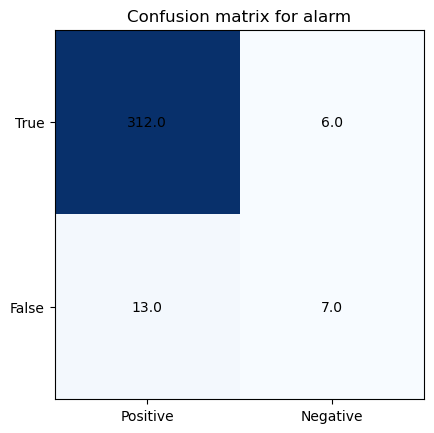

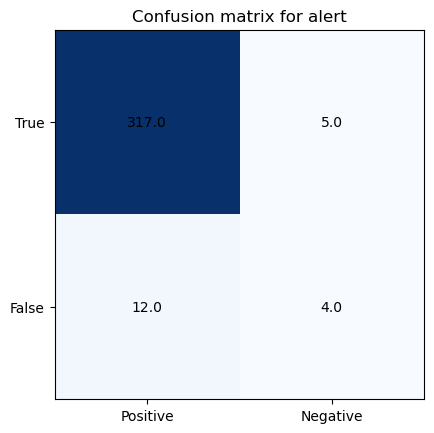

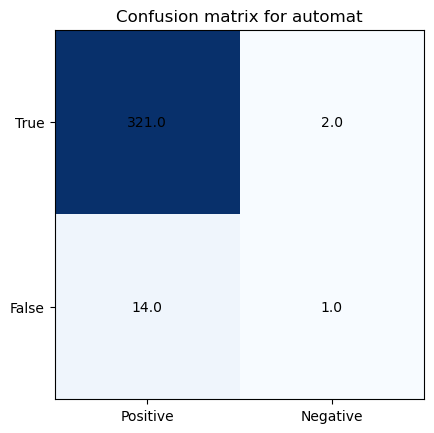

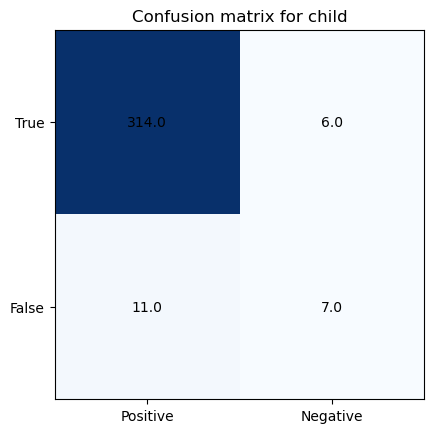

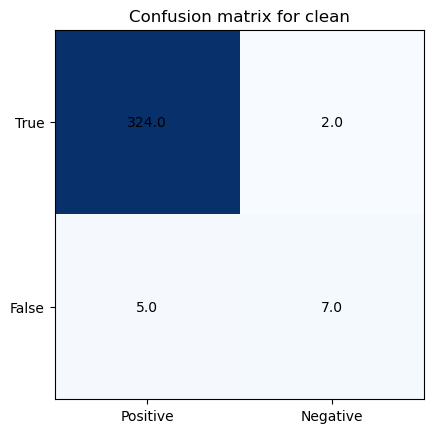

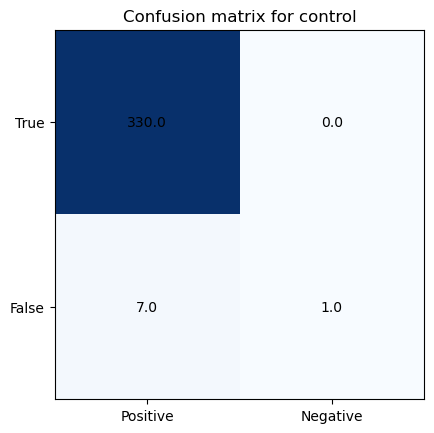

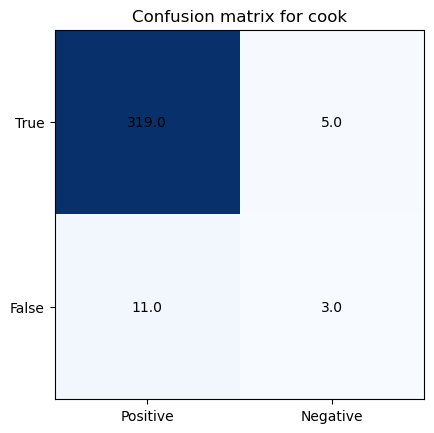

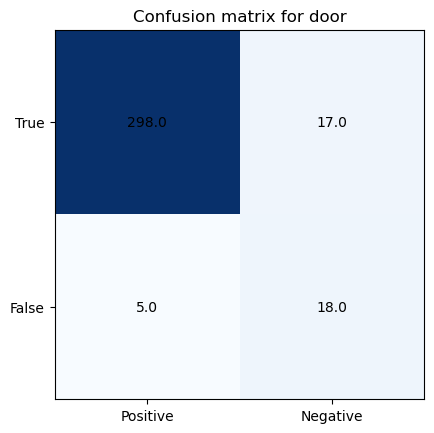

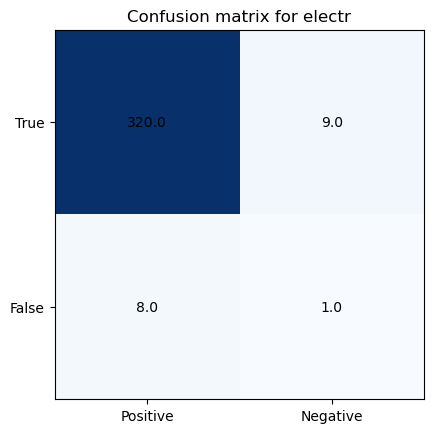

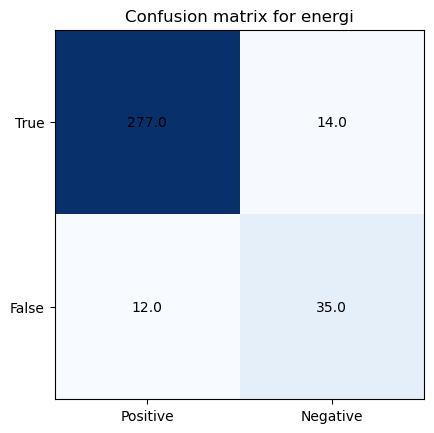

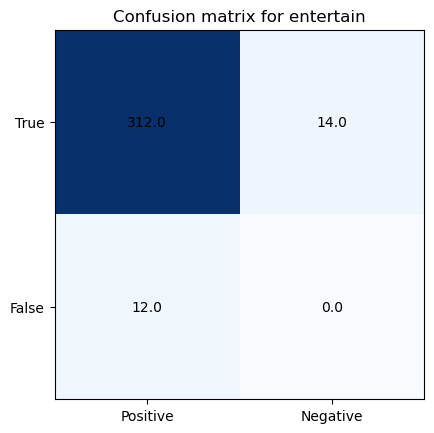

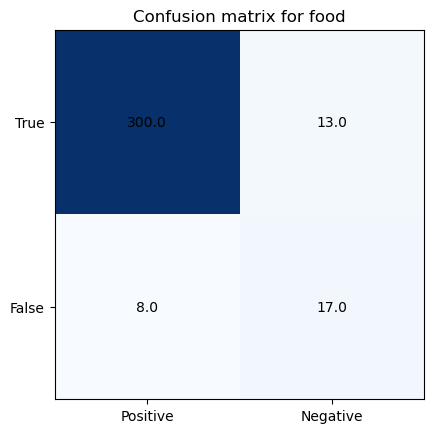

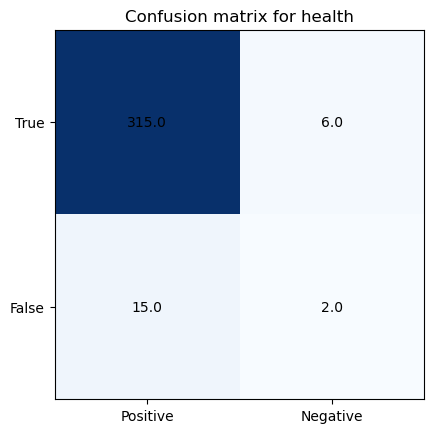

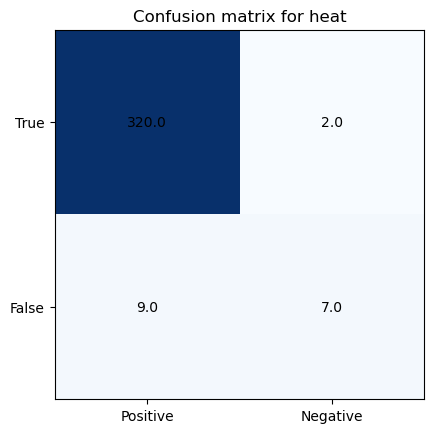

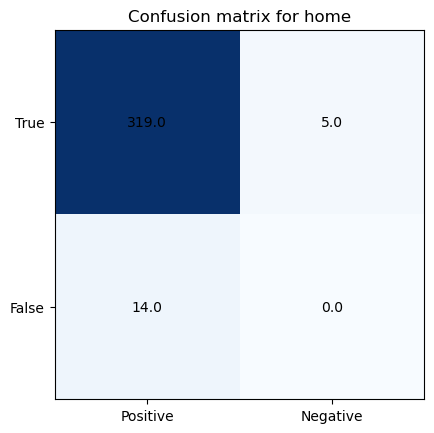

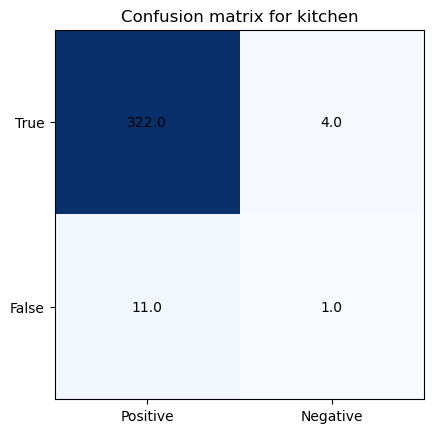

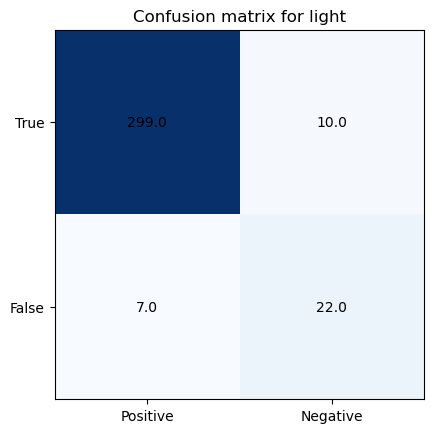

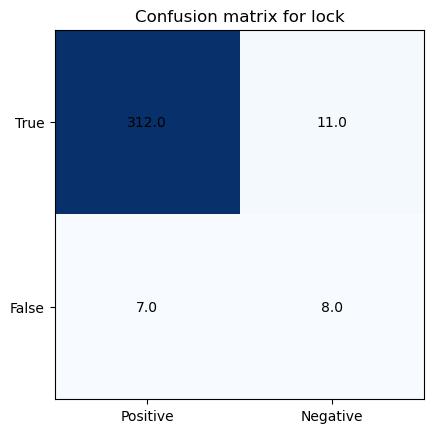

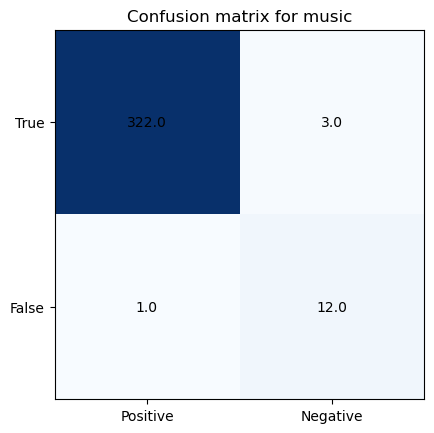

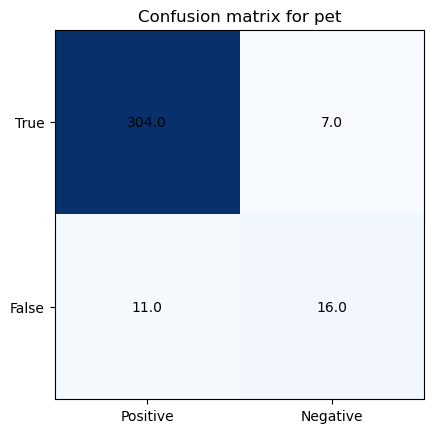

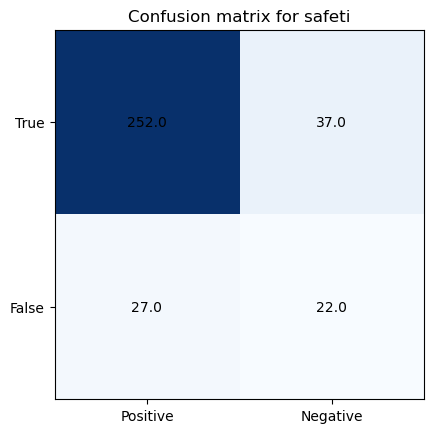

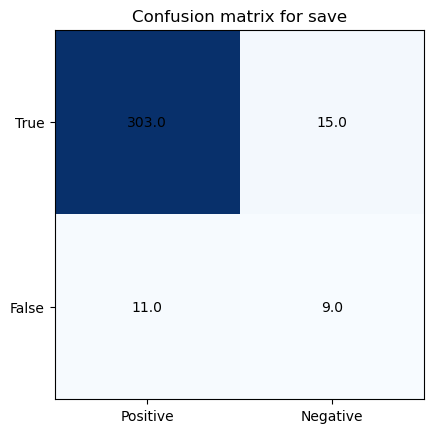

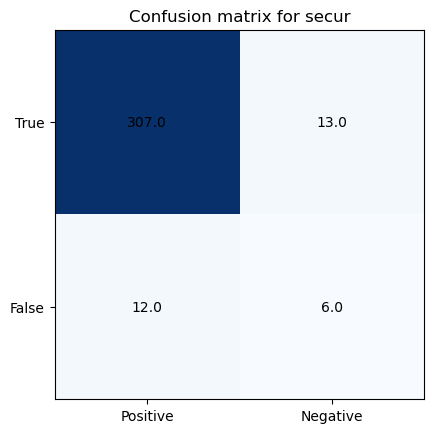

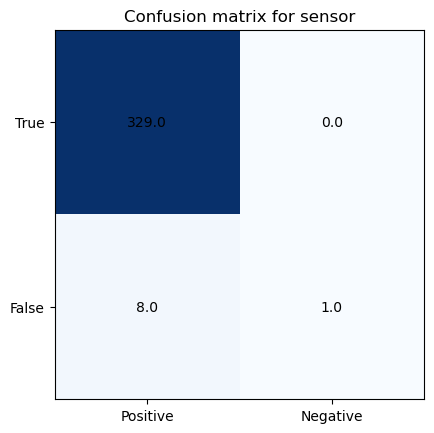

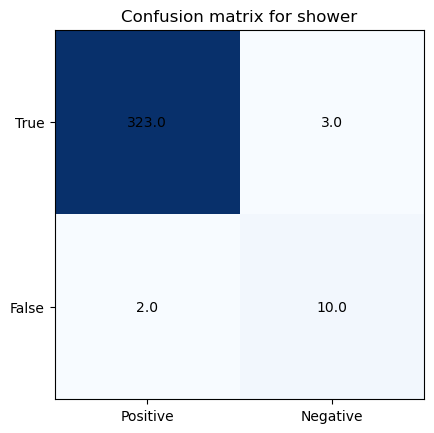

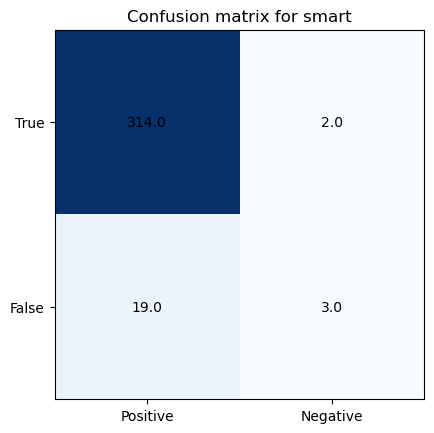

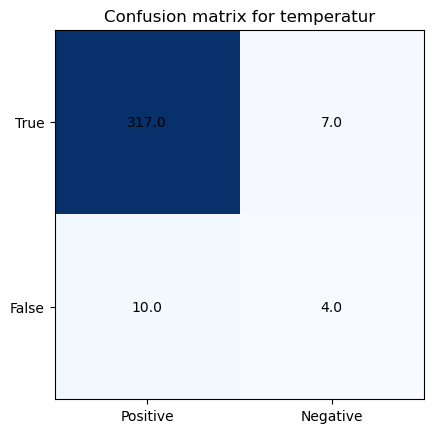

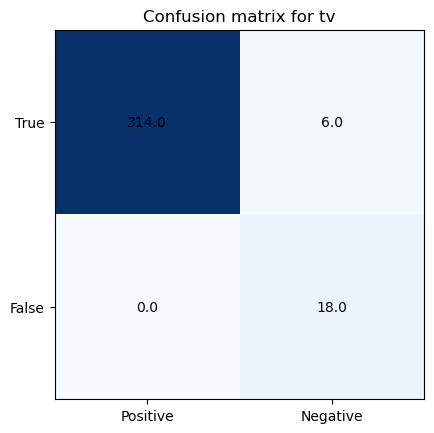

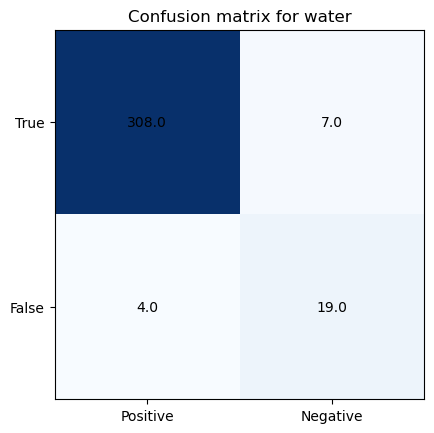

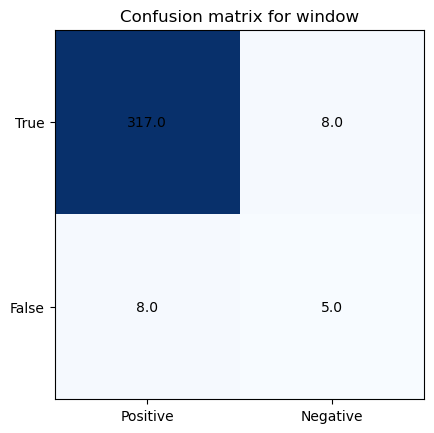

In [16]:
from sklearn.metrics import multilabel_confusion_matrix

y_true = []
y_pred = []

if y_test.shape[0] == predicted_NB.shape[0]:
    for i in range(y_test.shape[0]):
        y_true.append(y_test[i])
        y_pred.append(predicted_NB[i])

y_true = np.array(y_test)
y_pred = np.array(predicted_NB)

# Assuming y_true and y_pred are the true and predicted labels, respectively
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
classes =  ['alarm','alert','automat','child','clean','control','cook','door',
 'electr', 'energi', 'entertain', 'food', 'health' ,'heat' ,'home' ,'kitchen',
 'light', 'lock', 'music', 'pet', 'safeti', 'save', 'secur','sensor', 'shower',
 'smart', 'temperatur', 'tv' ,'water', 'window']# List of class labels

# Plot the confusion matrix for each label
for i, label in enumerate(classes):
    fig, ax = plt.subplots()
    mat = confusion_matrices[i]
    ax.imshow(mat, cmap='Blues')
    for (j, k), z in np.ndenumerate(mat):
        ax.text(k, j, '{:0.1f}'.format(z), ha='center', va='center')

    ax.set_title('Confusion matrix for ' + label)
    ax.set_xticks(np.arange(len(mat)))
    ax.set_yticks(np.arange(len(mat)))
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True','False'])  
    plt.show()

In [17]:
SVC_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
 
SVC_pipeline.fit(X_train,y_train)
predicted_SVC = SVC_pipeline.predict(X_test)
print_evaluation_scores(y_test,predicted_SVC)

accuracy: 0.1893491124260355
f1_score_macro: 0.39636212088858674
f1_score_micro: 0.4499484004127967
f1_score_weighted: 0.43555307827449447


/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/d

In [18]:
LogReg_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
            ])
 
LogReg_pipeline.fit(X_train,y_train)
predicted_Log = LogReg_pipeline.predict(X_test)
print_evaluation_scores(y_test,predicted_Log)

accuracy: 0.14792899408284024
f1_score_macro: 0.31666034512456526
f1_score_micro: 0.39030612244897955
f1_score_weighted: 0.35217184178672867


In [19]:
knn_pipeline = Pipeline([
    ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
    ('clf', OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1))
])

# Fit the pipeline on training data
knn_pipeline.fit(X_train,y_train)

predicted_knn = knn_pipeline.predict(X_test)
print_evaluation_scores(y_test,predicted_knn)

accuracy: 0.0650887573964497
f1_score_macro: 0.13346993877711572
f1_score_micro: 0.18844984802431608
f1_score_weighted: 0.16630533519485868


In [20]:
tfidf = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
feature = tfidf.fit_transform(X_train)
print(feature.shape)
print(feature)

(1431, 767)
  (0, 720)	0.31452873918531016
  (0, 316)	0.321316656066815
  (0, 609)	0.14605585286694914
  (0, 761)	0.24567194685648708
  (0, 171)	0.2112631812931531
  (0, 417)	0.27055757560369526
  (0, 213)	0.25269466261139883
  (0, 185)	0.28608130536901766
  (0, 522)	0.2983405049809683
  (0, 144)	0.29391738032733966
  (0, 718)	0.23950270534839038
  (0, 275)	0.20076018028608517
  (0, 494)	0.321316656066815
  (0, 5)	0.21745931191360152
  (0, 315)	0.11403966519259079
  (0, 608)	0.1265343889280246
  (1, 140)	0.47964904341122966
  (1, 330)	0.4168843564831488
  (1, 336)	0.22527199151350613
  (1, 139)	0.3511562225550549
  (1, 397)	0.26833667382977916
  (1, 117)	0.3168867857039218
  (1, 690)	0.24474680104808702
  (1, 609)	0.21283599833444314
  (1, 315)	0.33236252453506626
  :	:
  (1428, 447)	0.17060673270089868
  (1428, 223)	0.16978002029046194
  (1428, 571)	0.12568611389379833
  (1428, 559)	0.2668577902749537
  (1428, 397)	0.13924879527208442
  (1428, 690)	0.38102168488078436
  (1428, 5)	0.16

In [21]:
tfidf_NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(MultinomialNB())),
            ])
 
tfidf_NB_pipeline.fit(X_train,y_train)
tfidf_NB_predicted = tfidf_NB_pipeline.predict(X_test)
print_evaluation_scores(y_test,tfidf_NB_predicted)

accuracy: 0.03254437869822485
f1_score_macro: 0.06396041592815786
f1_score_micro: 0.1040268456375839
f1_score_weighted: 0.09005917565537383


In [22]:
tfidf_SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

tfidf_SVC_pipeline.fit(X_train,y_train)
tfidf_SVC_predicted = tfidf_SVC_pipeline.predict(X_test)

print_evaluation_scores(y_test,tfidf_SVC_predicted)

accuracy: 0.1952662721893491
f1_score_macro: 0.37498946122622107
f1_score_micro: 0.46282973621103113
f1_score_weighted: 0.4162026524771447


/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/d

In [23]:
tfidf_LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
            ])
 
tfidf_LogReg_pipeline.fit(X_train,y_train)
tfidf_LogReg_predicted = tfidf_LogReg_pipeline.predict(X_test)
print_evaluation_scores(y_test,tfidf_LogReg_predicted)

accuracy: 0.07396449704142012
f1_score_macro: 0.13090574899770302
f1_score_micro: 0.1824
f1_score_weighted: 0.15537640971507966


In [24]:
tfidf_knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
    ('clf', OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1))
])

# Fit the pipeline on training data
tfidf_knn_pipeline.fit(X_train,y_train)

tfidf_knn_predicted = tfidf_knn_pipeline.predict(X_test)
print_evaluation_scores(y_test,tfidf_knn_predicted)

accuracy: 0.11242603550295859
f1_score_macro: 0.23662442284776972
f1_score_micro: 0.3013698630136986
f1_score_weighted: 0.27221344910696593


In [25]:
# allocate tags for set 1
# set 1 data
scenarios = pd.read_csv('../../cleaned_dataset/senario.csv')
sc = pd.DataFrame(scenarios, columns = ['id','context','stimuli','response'])
sc['sentence']= sc['context'] + ', ' + sc['stimuli'] + ', ' +sc['response']
sc.drop(['context','stimuli','response'],axis=1, inplace=True)
sc.dropna(inplace=True)
sc.reset_index(drop=True, inplace=True)
sc.columns=['scenarios_id','sentence']
cv = sc.copy()
tf = sc.copy()
sc.head()

,scenarios_id,sentence
0,7,"my sensor should detect movement, if i get up ..."
1,8,the house should automatically detect movement...
2,9,"movement should be detected, if there is movem..."
3,10,"if a person is reading, the house should chang..."
4,11,There is a storm outside or it is very hot and...


In [26]:
# clean set 1 sentence
XX_test = sc['sentence']
print(type(XX_test[0]))
XX_test[:10]

<class 'str'>


0    my sensor should detect movement, if i get up ...
1    the house should automatically detect movement...
2    movement should be detected, if there is movem...
3    if a person is reading, the house should chang...
4    There is a storm outside or it is very hot and...
5    A late night shopping trip., A person gets hom...
6    Someone with malicious intent is scoping out t...
7    It is night time and a couple are having a rel...
8    A dog or cat is moving around making it seem l...
9    The lights should turn off after a set period ...
Name: sentence, dtype: object

In [27]:
Xx_test = [text_prepare(x) for x in XX_test]
Xx_test[:10]

['sensor detect movement get late night lights house go',
 'house automatically detect movement person walks dark room lights go enhance convenience safety',
 'movement detected movement outside house lights go visibility dark night',
 'person reading house change lightning brightness color lights turn bright white person see reading',
 'storm outside hot ac blowing cool air house wind fan may blowing curtains system able determine continuous motion small degree therefore register continue shut lights designated time',
 'late night shopping trip person gets home late night hands full cant switch lights system instantly turn lights motion detected',
 'someone malicious intent scoping house potentially rob person prowling around yard smart homeowner exterior lights recognize normal times guest authorized person key holder turn lights',
 'night time couple relaxing glass whine watching movie evening man romantic house guest sitting couch living room light system recognize getting late mov

In [28]:
set1_predicted_SVC = SVC_pipeline.predict(Xx_test)
set1_predicted_SVC

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
set1_predicted_tfidf_LSVC = tfidf_knn_pipeline.predict(Xx_test)
set1_predicted_tfidf_LSVC

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
cv_tags = mlb.inverse_transform(set1_predicted_SVC)
cv['tags'] = cv_tags
cv.head()

,scenarios_id,sentence,tags
0,7,"my sensor should detect movement, if i get up ...","(sensor,)"
1,8,the house should automatically detect movement...,()
2,9,"movement should be detected, if there is movem...","(light,)"
3,10,"if a person is reading, the house should chang...","(control, safeti)"
4,11,There is a storm outside or it is very hot and...,"(light,)"


In [31]:
tf_tags = mlb.inverse_transform(set1_predicted_tfidf_LSVC)
tf['tags'] = tf_tags
tf.head()

,scenarios_id,sentence,tags
0,7,"my sensor should detect movement, if i get up ...","(light,)"
1,8,the house should automatically detect movement...,()
2,9,"movement should be detected, if there is movem...",()
3,10,"if a person is reading, the house should chang...",()
4,11,There is a storm outside or it is very hot and...,()


In [32]:
pre_count = 0
count = 0
for tags, index in zip(cv['tags'],range(len(cv['tags']))):
    if len(tags)==0:
        cv['tags'][index] = tf['tags'][index]
        pre_count += 1
    if len(cv['tags'][index])==0:
        count += 1
        
print('pre_count', pre_count)
print('count', count)
cv.head()
        
        

pre_count 141
count 111


/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_38271/3611089730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['tags'][index] = tf['tags'][index]
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_38271/3611089730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['tags'][index] = tf['tags'][index]
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_38271/3611089730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

,scenarios_id,sentence,tags
0,7,"my sensor should detect movement, if i get up ...","(sensor,)"
1,8,the house should automatically detect movement...,()
2,9,"movement should be detected, if there is movem...","(light,)"
3,10,"if a person is reading, the house should chang...","(control, safeti)"
4,11,There is a storm outside or it is very hot and...,"(light,)"


In [33]:
cv.set_index('scenarios_id',inplace=True)
cv.to_csv('./predicted_tags.csv')